#### Imports

In [7]:
import numpy as np
from skimage.color import rgb2gray
from skimage.filters import sobel
from skimage.measure import regionprops, label
from skimage.filters import threshold_otsu
from skimage.util import img_as_float
from skimage import exposure 
from skimage.io import imread
import os
import pandas as pd
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib.cbook import get_sample_data

#### Utils

In [8]:
def process_galaxy_image_folder(folder_path, file_exts=('.jpg', '.jpeg', '.png')):
    """
    Processes all image files in the given folder and extracts features.
    
    Parameters:
    - folder_path: path to folder with images
    - file_exts: tuple of allowed image extensions
    
    Returns:
    - pandas DataFrame with extracted features
    - list of failed filenames (for debugging)
    """
    results = []
    failed = []

    fnames = os.listdir(folder_path)
    for i,filename in enumerate(fnames):
        if not filename.lower().endswith(file_exts):
            continue
        print(f'{i}/{len(fnames)}', flush=True, end='\r')

        filepath = os.path.join(folder_path, filename)
        try:
            img = imread(filepath)
            feats = extract_galaxy_features_from_image(img)
            if feats is None:
                failed.append(filename)
                continue
            feats['filename'] = filename
            results.append(feats)
        except Exception as e:
            failed.append(filename)
            print(f"Failed to process {filename}: {e}")

    df = pd.DataFrame(results)
    return df, failed

In [9]:
def extract_galaxy_features_from_image(img):
    """
    Extract basic features (similar to those we use in actual science) 
    from a centered 3-channel galaxy image (e.g. 128x128 JPG).
    
    Returns a dict with:
    - eccentricity
    - area (of main object)
    - orientation (in radians)
    - edge_density
    - mean_red, mean_green, mean_blue
    - red_minus_blue (color index proxy)
    """
    img = img_as_float(img)  # scale to [0, 1]
    
    # Color channels
    red = img[:, :, 0]
    green = img[:, :, 1]
    blue = img[:, :, 2]

    # Greyscale + Otsu threshold for object detection
    gray = rgb2gray(img)
    thresh = threshold_otsu(gray)
    binary = gray > thresh
    labeled = label(binary)

    # Select the largest region (assuming centered galaxy)
    props = regionprops(labeled)
    if not props:
        return None  # nothing detected

    region = max(props, key=lambda r: r.area)

    # Basic shape features
    eccentricity = region.eccentricity
    area = region.area
    orientation = region.orientation  # radians, -pi/2 to pi/2

    # Edge-based smoothness proxy
    edges = sobel(gray)
    edge_density = np.mean(edges)

    # Color features
    mean_red = np.mean(red)
    mean_green = np.mean(green)
    mean_blue = np.mean(blue)
    color_index = mean_red - mean_blue  # proxy for R-B color

    return {
        'eccentricity': eccentricity,
        'area': area,
        'orientation': orientation,
        'edge_density': edge_density,
        'mean_red': mean_red,
        'mean_green': mean_green,
        'mean_blue': mean_blue,
        'red_minus_blue': color_index,
    }

In [10]:
def crop_image(image,cut_size=128):
    cut_val = (image.shape[0] - cut_size)//2
    image = image[cut_val:-cut_val,cut_val:-cut_val]
    return image

In [11]:
def plot_cutouts(X_embedded,fnames,zoom=0.1):
    x = X_embedded[:,0]
    y = X_embedded[:,1]
    fig, ax = plt.subplots(figsize=(20,20))
    imscatter(x, y, fnames, zoom=zoom, ax=ax)
    plt.show()

In [12]:
def imscatter(x, y, images, ax=None, zoom=1):
    if ax is None:
        ax = plt.gca()
    artists = []
    for x0, y0, imgpath in zip(x, y,images):
        image = plt.imread(os.path.join(dirs['source_images'],imgpath))
        image = crop_image(image)
        im = OffsetImage(image, zoom=zoom)
        ab = AnnotationBbox(im, (x0, y0), xycoords='data', frameon=False)
        artists.append(ax.add_artist(ab))
    ax.update_datalim(np.column_stack([x, y]))
    ax.autoscale()
    return artists

#### Load the dataset

In [19]:
dirs = {}
dirs['source_images'] = '/mnt/Data/Work/Sources/Petnica/galzoo/small_sample'
dirs['features'] = '/mnt/Data/Work/Sources/Petnica/features'

In [14]:
fnames = os.listdir(dirs['source_images'])

##### If you have skimage installed

In [15]:
# Run feature extractor on one file to see how it works
img = imread(os.path.join(dirs['source_images'],fnames[0]))
features = extract_galaxy_features_from_image(img)
print(features)

{'eccentricity': 0.7125692025505649, 'area': np.float64(9493.0), 'orientation': -0.6671185782664735, 'edge_density': np.float64(0.006581992521027388), 'mean_red': np.float64(0.04390441874507012), 'mean_green': np.float64(0.034645859945971975), 'mean_blue': np.float64(0.02945432311408009), 'red_minus_blue': np.float64(0.014450095630990027)}


In [16]:
df, bad_files = process_galaxy_image_folder(dirs['source_images'])
print("Extracted features for:", len(df), "images")
print("Failed files:", len(bad_files))

Extracted features for: 2000 images
Failed files: 0


In [18]:
df.head()

,eccentricity,area,orientation,edge_density,mean_red,mean_green,mean_blue,red_minus_blue,filename
0,0.712569,9493.0,-0.667119,0.006582,0.043904,0.034646,0.029454,0.014450,105167.jpg
1,0.946808,13337.0,1.393934,0.008689,0.055662,0.047370,0.034221,0.021441,152494.jpg
2,0.619545,7669.0,-0.883620,0.010609,0.044544,0.036542,0.026179,0.018365,100008.jpg
3,0.787417,6063.0,0.389924,0.006849,0.034905,0.031153,0.018949,0.015955,100018.jpg
4,0.915843,7973.0,0.636694,0.006339,0.044840,0.038196,0.026497,0.018343,100023.jpg


In [20]:
df.to_csv(os.path.join(dirs['features'],'cv_galzoo_features.csv'),index=False)

##### If not, just load the features from the file

In [22]:
df = pd.read_csv(os.path.join(dirs['features'],'cv_galzoo_features.csv'))

#### Run TSNE on these features

In [23]:
features_only = df.drop(columns=["filename"])
scaled = StandardScaler().fit_transform(features_only)

tsne = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_coords = tsne.fit_transform(scaled)

df['tsne_x'] = tsne_coords[:, 0]
df['tsne_y'] = tsne_coords[:, 1]


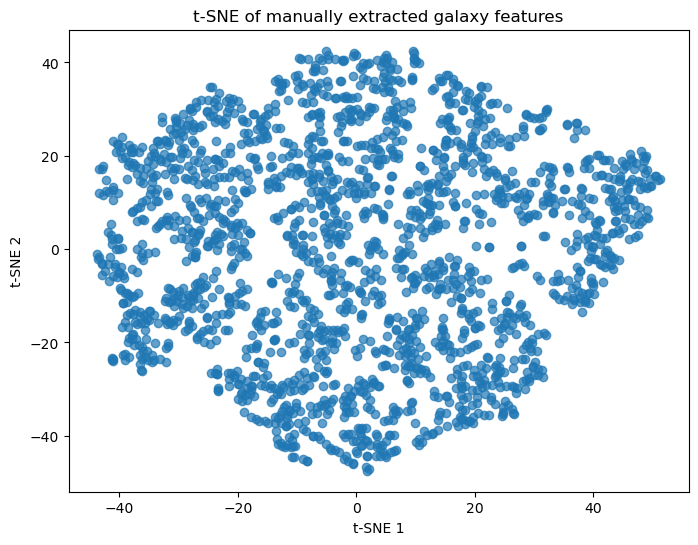

In [24]:
plt.figure(figsize=(8, 6))
plt.scatter(df['tsne_x'], df['tsne_y'], alpha=0.7)
plt.title("t-SNE of manually extracted galaxy features")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.show()

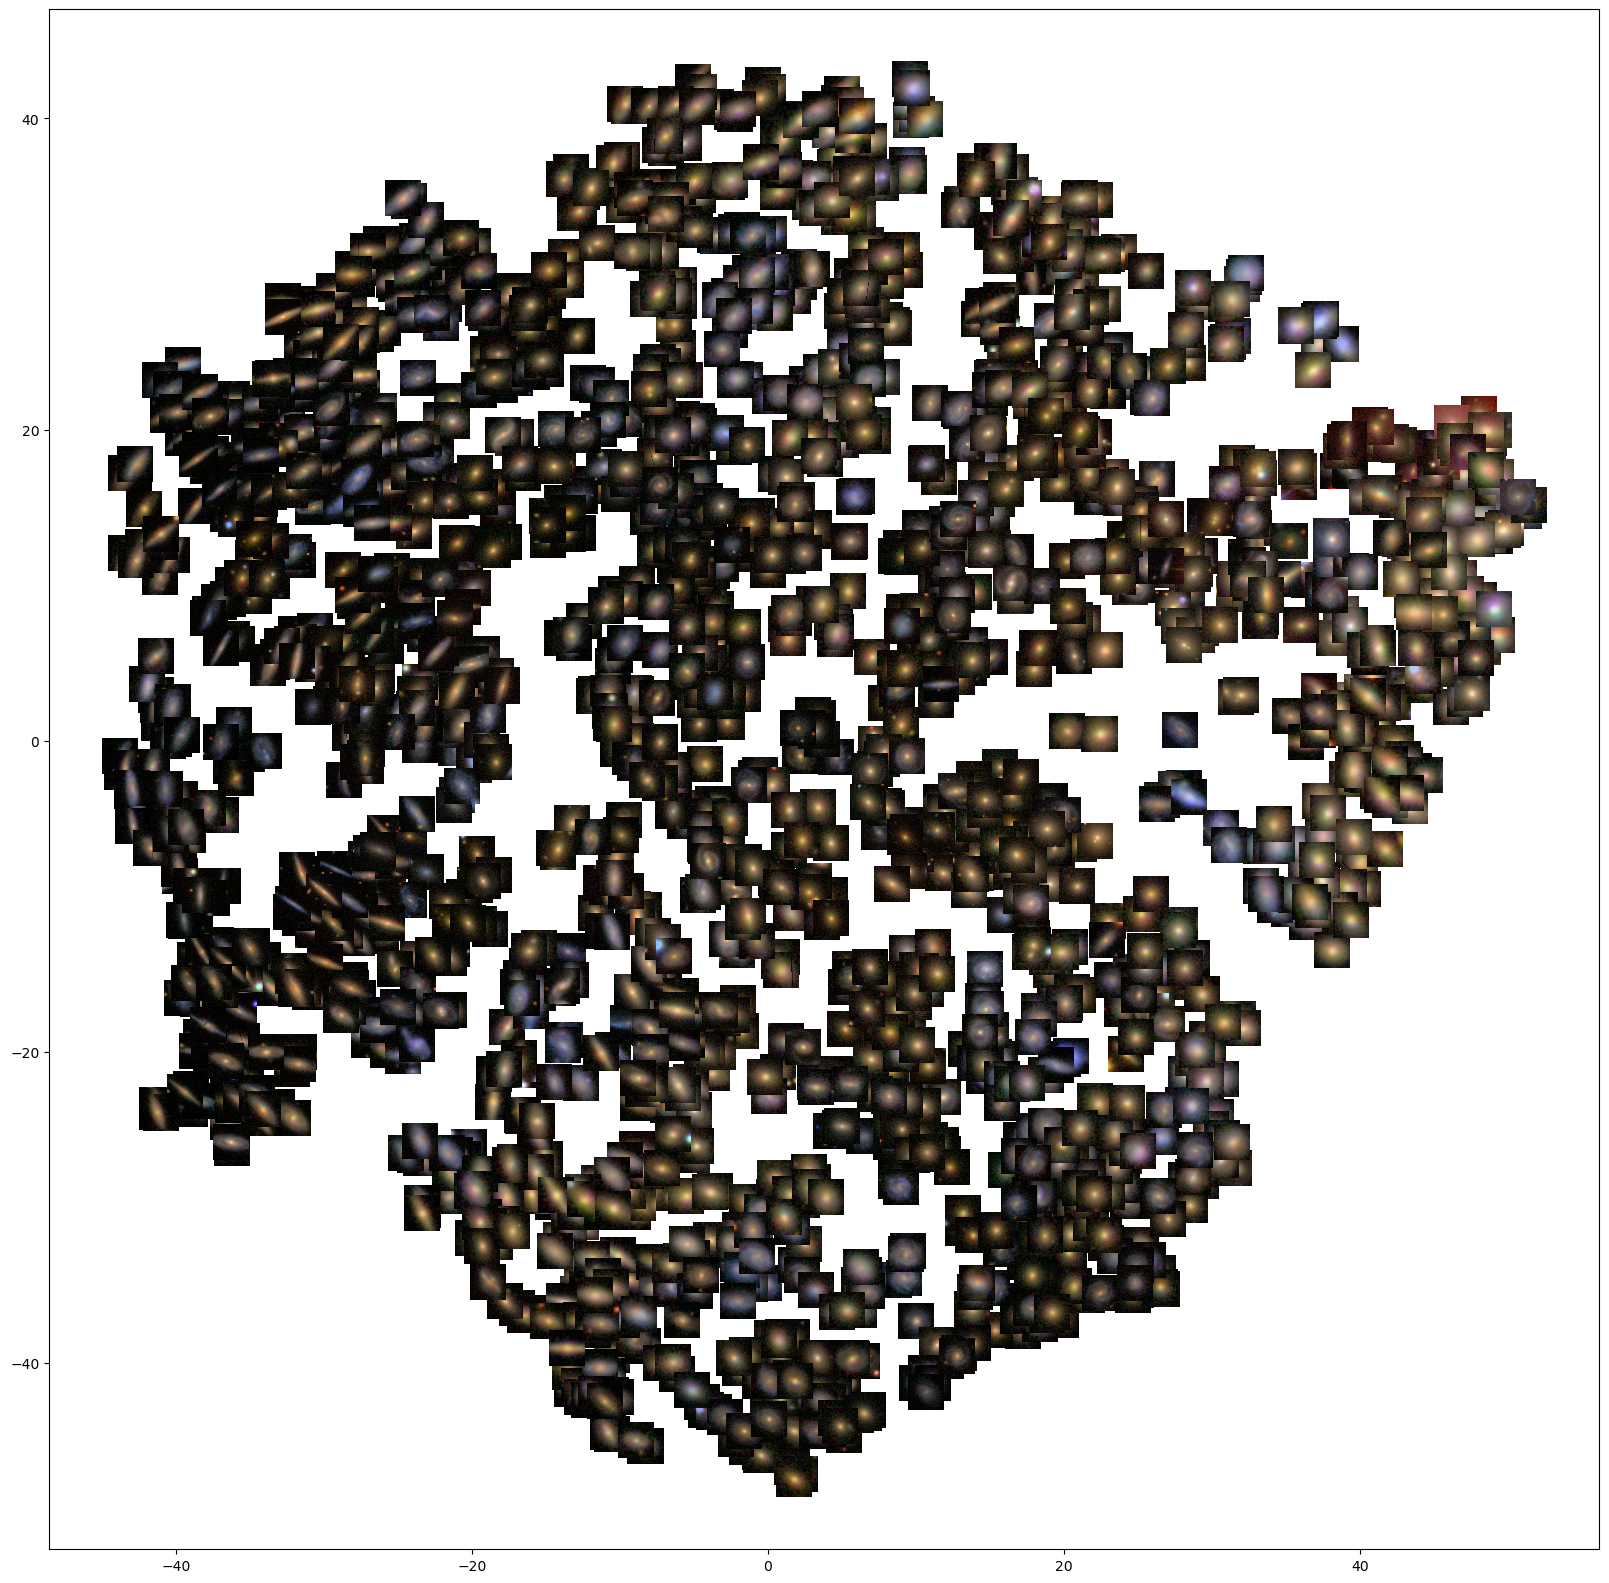

In [25]:
plot_cutouts(np.array(df[['tsne_x','tsne_y']]),fnames,zoom=0.2)